INFO284
Machine Learning on Fisheries Data

Problemstilling:

Vi ønsker at vårt program skal gi en prediksjon på hvor stor andel av de fem mest populære fiskeartene et fiskefartøy kan forvente å få. Mengden regnes i kilo per fiskeart, altså fangst per fartøy av den spesifikke arten i rundvekt. 
Parametere vi skal se på for å predikere dette er diverse egenskaper som; fartøyets størrelse i bredde og lengde, hvilke redskap fartøyet benytter, lokasjonen hvor fartøyet har fisket, samt et anslag av tid på døgnet på når de har fisket.

Vi bruker følgende standardbiblioteker i Python for å effektivisere vår dataanalyse og maskinlæringsarbeid.

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import seaborn as sns
import calendar
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from statistics import mode

Vi laster inn datasettet vårt og lager en dataframe:

In [95]:
df = pd.read_csv('elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv', delimiter=';')

### Fjerning av features

Vi begrunner vårt valg av features i at vi ønsker å samle informasjon om enkeltturer for fiskebåter. Vi ønsker å analysere hvor fiskeriet foregår, når og over hvor lang tid dette skjer, størrelse på fartøy og hva slags utstyr som er brukt samt hva fisketuren resulterte i mtp. nettovekt fangst og arter som ble fisket.
Etter en nøye vurdering av hver enkelt feature har vi valgt å utelukke følgende kolonner for å forbedre modellen fordi vi anser de som irrelevante i forhold til hva vi ønsker å predikere:

##### Meldingstidspunkt, Meldingsdato, Meldingsklokkeslett: 
Irrelevant fordi de representerer tidspunktet for rapportering og ikke den faktiske fiskeaktiviteten.

##### Starttidspunkt, Stopptidspunkt, Stoppdato, Stoppklokkeslett: 
Vi bruker en kombinasjon av startklokkeslett og varighet for å representere tidsaspektet ved fiskeaktiviteten, og deretter representerer tiden ved hjelp av sin og cos verdier. Siden vi tar høyde for varigheten trenger vi heller ikke eksakte sluttider.

##### Fangstår: 
Uvesentlig da alt av fangst i datasettet skjedde i 2018.

##### Hovedoråde start (kode), Hovedområde stopp (kode): 
Unødvendig ettersom det er duplikat informasjon for Hovedområde start og Hovedområde stopp.

##### Redskap FAO (kode), Redskap FAO, Redskap FDIR (kode):
Overlapper med Redskap FDIR som vi velger å beholde. 

##### Hovedart FAO (kode), Hovedart FAO, Hovedart - FDIR (kode), Art FAO (kode), Art - FDIR (kode), Art - FDIR: 
Disse variablene blir overflødig i og med at de overlapper med Art FAO som vi velger å beholde.

##### Art - gruppe (kode), Art - gruppe: 
Vår model rettes mot spesifikke arter fremfor grupper.

##### Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen: 
Selve lengegruppen ser vi på som irrelevant. Vi bruker en kombinert beregning av båtens størrelse basert på lengde og bredde.

Kode for fjerning av kolonner vi ser på som irrelevante:

In [96]:
columns_to_remove = [
    "Meldingstidspunkt", "Meldingsdato", "Meldingsklokkeslett",
    "Starttidspunkt", 
    "Hovedområde start (kode)", "Stopptidspunkt", "Stoppdato", "Stoppklokkeslett",
    "Fangstår", 
    "Hovedområde stopp (kode)", "Redskap FAO (kode)", "Redskap FAO",
    "Redskap FDIR (kode)", "Hovedart FAO (kode)", "Hovedart FAO",
    "Hovedart - FDIR (kode)", "Art FAO (kode)", "Art - FDIR (kode)",
    "Art - FDIR", "Art - gruppe (kode)", "Art - gruppe", "Lengdegruppe",
    "Bruttotonnasje 1969", "Bruttotonnasje annen", "Lengdegruppe (kode)"
]

df = df.drop(columns=columns_to_remove)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Melding ID             305434 non-null  int64  
 1   Startdato              305434 non-null  object 
 2   Startklokkeslett       305434 non-null  object 
 3   Startposisjon bredde   305434 non-null  object 
 4   Startposisjon lengde   305434 non-null  object 
 5   Hovedområde start      301310 non-null  object 
 6   Lokasjon start (kode)  303433 non-null  float64
 7   Havdybde start         305434 non-null  int64  
 8   Varighet               305434 non-null  int64  
 9   Stopposisjon bredde    305434 non-null  object 
 10  Stopposisjon lengde    305434 non-null  object 
 11  Hovedområde stopp      301310 non-null  object 
 12  Lokasjon stopp (kode)  303472 non-null  float64
 13  Havdybde stopp         305434 non-null  int64  
 14  Trekkavstand           305410 non-nu

### Analyse av null- og non-verdier

Ser på null- og non-verdiene som finnes i datasettet. Sjekker om de null- og non-verdiene som er i dataen korrelerer til en spesifikk feature for å se om vi eventuelt kan droppe én feature som inneholder mange null- og non-verdier. 

Dropped Data:
        Melding ID   Startdato Startklokkeslett  Startposisjon bredde  \
0          1497177  31.12.2017            00:00               -60.350   
66         1497323  01.01.2018            02:30                60.374   
109        1497346  30.12.2017            13:56               -72.908   
110        1497346  31.12.2017            03:40               -72.773   
143        1497359  31.12.2017            23:47               -60.417   
...            ...         ...              ...                   ...   
305316     1800252  31.12.2018            11:30                89.450   
305317     1800252  31.12.2018            11:30                89.450   
305318     1800252  31.12.2018            11:30                89.450   
305319     1800252  31.12.2018            11:30                89.450   
305320     1800252  31.12.2018            11:30                89.450   

        Startposisjon lengde Hovedområde start  Lokasjon start (kode)  \
0                    -46.133        

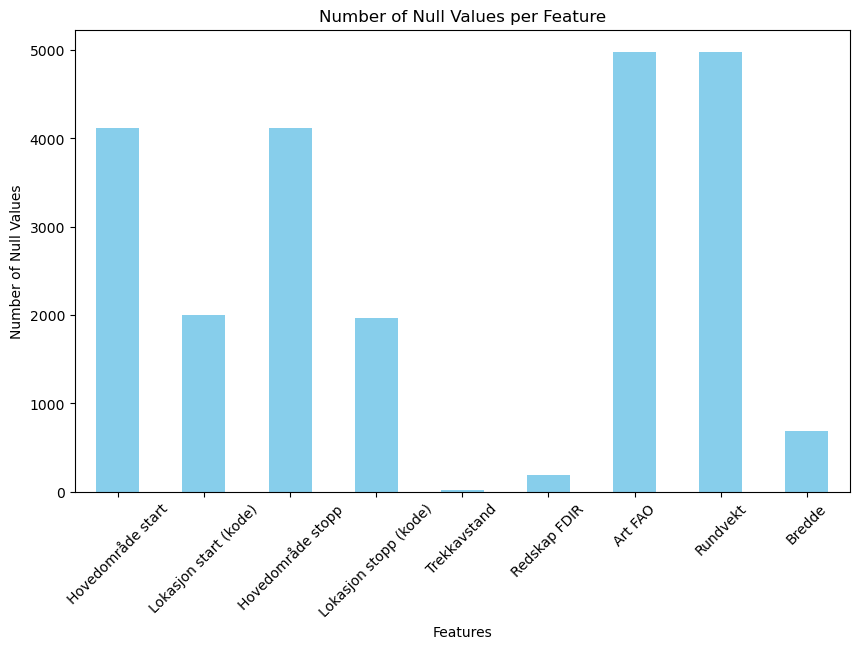

In [97]:
columns_to_check = ['Bredde','Fartøylengde','Startposisjon bredde', 'Startposisjon lengde','Stopposisjon bredde','Stopposisjon lengde']

for column in columns_to_check:
    df[column] = pd.to_numeric(df[column].str.replace(',', '.'), errors='coerce')

data_to_drop  = df[df.isnull().any(axis=1)]

percentage_to_drop = (len(data_to_drop) / len(df)) * 100

print("Dropped Data:")
print(data_to_drop)
print(f"Percentage of dropped data compared to the original data: {percentage_to_drop:.2f}%")

null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0] 
if not null_counts.empty:
    null_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
    plt.title('Number of Null Values per Feature')
    plt.xlabel('Features')
    plt.ylabel('Number of Null Values')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No features have null values.")


Null verdiene i grafen over er fordelt ut over flere ulike features. Vi må å beholde Art FAO og Rundvekt for å kunne finne ut av det vi ønsker i oppgaven, selv om disse hadde flest null-verdier. Vi merker oss også at 'Hovedområde start', 'Lokasjon start (kode)', 'Hovedområde stopp' og 'Lokasjon stopp (kode)' har mange null-verdier til sammen, og vi ser derfor på muligheten for å droppe disse featurene før vi tar dropna for å fjerne resterende null verdier. Før vi bestemmer oss for om vi skal droppe disse featurene ønsker vi å se hvor mange rader det kun er én null-verdi, og om dette korrelerer med én feature, eller om det er spredt utover.

There are 1046 single null values in a row in the dataset.


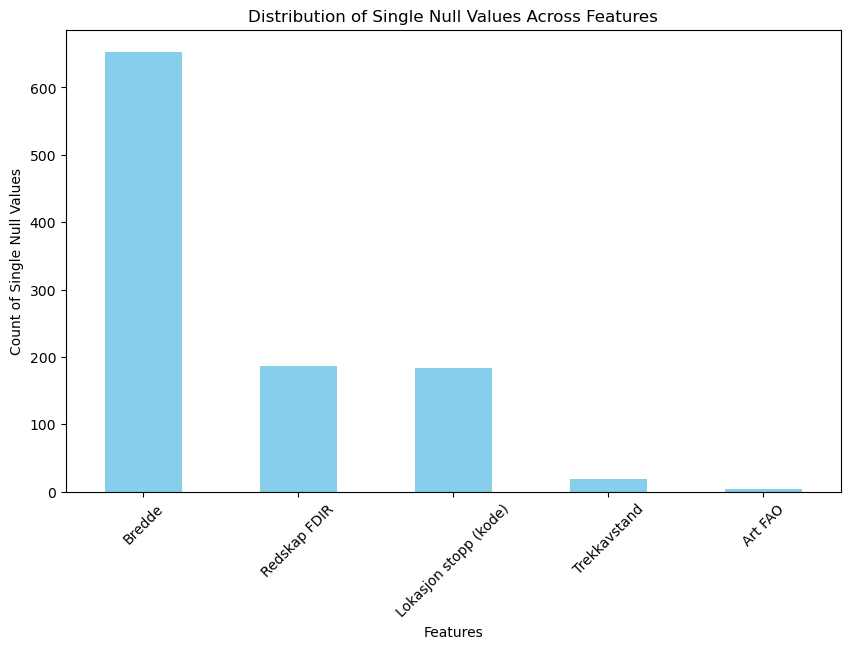

In [98]:
single_null_rows = {}

for index, row in df.iterrows():
    null_count = row.isnull().sum()
    if null_count == 1: 
        null_feature = row.index[row.isnull()][0]  
        single_null_rows[index] = null_feature  

null = 0
for index, feature in single_null_rows.items():
    null += 1
print(f"There are {null} single null values in a row in the dataset.")


if single_null_rows:
    single_null_counts = pd.Series(single_null_rows.values()).value_counts()
    single_null_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
    plt.title('Distribution of Single Null Values Across Features')
    plt.xlabel('Features')
    plt.ylabel('Count of Single Null Values')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("There are no rows with only one null value.")

#### Identifisere hvilke kolonner som bidrar til forekomsten av kun én nullverdi på en rad

Det er ikke særlig mange enslige null- og non-verdier i kategoriene Hovedområde start, Lokasjon start (kode), Hovedområde stopp og Lokasjon stopp (kode), foruten en liten forekomst i Lokasjon stopp (kode). Vi sjekker under hvor mange unike verdier det er i Lokasjon start (kode) og Hovedområde start, og ser at dette er såpass mange at vi tenker at det er uhensiktsmessig å one-hot-encode verdiene, siden vi da vil få veldig mange kolonner. Vi velger å fjerne kategoriene og håper at det vil gjøre at færre linjer slettes ved bruk av dropna. 
Når vi sammenligner grafene ser vi at alle null-verdiene til Bredde er single null-verdier på sine rader. Det er få verdier og vi behøver Bredde så vi velger å ikke fjerne den. Ettersom null verdiene er spredt utover flere ulike features og ikke hovedsaklig innen én velger vi å beholde resten av featurene og heller bruke dropna. Sjekker også hvor stor andel av det originale datasettet som fjernes ved bruk av dropna, og ser at dette er et såpass lite at det går fint å droppe det fra datsettet.

In [99]:
unique_values_count_lokasjon = df['Lokasjon start (kode)'].nunique()
unique_values_count_hovedområde = df['Hovedområde start'].nunique()

print("Number of unique values in", 'Lokasjon start (kode)', ":", unique_values_count_lokasjon)
print("Number of unique values in", 'Hovedområde start', ":", unique_values_count_hovedområde)

Number of unique values in Lokasjon start (kode) : 83
Number of unique values in Hovedområde start : 55


In [100]:
columns_to_remove = ['Hovedområde start', 'Lokasjon start (kode)', 'Hovedområde stopp', 'Lokasjon stopp (kode)']

df = df.drop(columns=columns_to_remove)

dropped_data = df[df.isnull().any(axis=1)]

percentage_dropped = (len(dropped_data) / len(df)) * 100

print("Dropped Data:")
print(dropped_data)
print(f"Percentage of dropped data compared to the original data: {percentage_dropped:.2f}%")

df = df.dropna()
df.reset_index(drop=True, inplace=True)

Dropped Data:
        Melding ID   Startdato Startklokkeslett  Startposisjon bredde  \
66         1497323  01.01.2018            02:30                60.374   
347        1497547  02.01.2018            08:50                63.115   
357        1497556  02.01.2018            10:42                68.108   
378        1497600  01.01.2018            19:48                60.567   
380        1497600  02.01.2018            07:30                60.368   
...            ...         ...              ...                   ...   
304937     1800073  30.12.2018            12:41                60.400   
304938     1800074  29.12.2018            18:49                60.294   
304944     1800074  30.12.2018            07:59                60.304   
305213     1800209  30.12.2018            22:38                60.567   
305217     1800213  31.12.2018            16:50                53.733   

        Startposisjon lengde  Havdybde start  Varighet  Stopposisjon bredde  \
66                    -3.604  

### Skipsstørrelse
For å minke andelen faktorer har vi bestemt oss for å slå sammen noen verdier. Fartøylengde og Bredde har vi slått sammen og navngitt 'Skipsstørrelse'. Denne faktoren er et areal av lengde * bredde på båten (som om den var kvadratisk). På denne måten er det en stor forskjell mellom en liten og en stor båt. Deretter fjerner vi de originale kolonnene 'Fartøyslengde' og 'Bredde' av den grunn at vi erstatter de med 'Skipsstørrelse'.

In [101]:
df['Skipsstørrelse'] = df['Fartøylengde'] * df['Bredde']

df.drop(['Fartøylengde', 'Bredde'], axis=1, inplace=True)

### Utvelgelse av arter

Vi ønsker å fokusere på 5 fiskearter i vår oppgave. Vi sorterer derfor Art FAO for å finne ut hvilke arter som har flest entries, samt hvilke arter som har mest fisk registrert i total rundvekt. Ut i fra denne informasjonen vil vi velge oss ut 5 fiskearter som er vanlige fiskearter basert på høy frekvens i fisketurer og mengde fisk i total rundvekt. 

In [102]:
column_name = 'Art FAO'

value_counts = df[column_name].value_counts()

sorted_value_counts = value_counts.sort_values(ascending=False)

print(sorted_value_counts.head(20))

Art FAO
Torsk            56507
Sei              42495
Hyse             39080
Lange            17328
Uer (vanlig)     14151
Dypvannsreke     13678
Brosme            9167
Lysing            8837
Breiflabb         8543
Blåkveite         8046
Flekksteinbit     8037
Snøkrabbe         6070
Sild              6000
Kveite            5649
Snabeluer         5408
Gråsteinbit       5389
Lyr               4863
Makrell           3008
Smørflyndre       2869
Kolmule           2843
Name: count, dtype: int64


In [103]:
column_name_fao = 'Art FAO'
column_name_weight = 'Rundvekt'

scores = df.groupby(column_name_fao)[column_name_weight].sum().sort_values(ascending=False)

print(scores.head(20))

Art FAO
Sild                  451205401.0
Kolmule               432020908.0
Torsk                 224782079.0
Antarktisk krill      205565085.0
Lodde                 189412864.0
Makrell               174524213.0
Sei                   166296587.0
Hyse                   76677153.0
Tobis og annen sil     69668067.0
Dypvannsreke           26163840.0
Øyepål                 25001483.0
Snabeluer              18113473.0
Lange                  15667185.0
Vassild                14635479.0
Blåkveite              11445871.0
Brisling               10863835.0
Hestmakrell            10305120.0
Brosme                  9177567.0
Uer (vanlig)            5203678.0
Strømsild               4900610.0
Name: Rundvekt, dtype: float64


Vi har fra disse to oversiktene valgt oss ut å fokusere på Torsk, Sei og Hyse fordi disse tre har veldig mange entries og i tillegg har relativt høy total rundvekt. Vi ønsker også å se på Sild og Makrell da disse er de to neste naturlige valgene når man ser på total rundvekt.
Dermed legger vi til kolonner for rundvekt pr./art. Artene er de fem vi har valgt å fokusere på.

In [104]:
columns = ["Torsk - rundvekt", "Sei - rundvekt", "Hyse - rundvekt", "Sild - rundvekt", "Makrell - rundvekt"]
positions = [4, 5, 6, 7, 8] 

for col, pos in zip(columns, positions):
    df.insert(pos, col, 0.0) 

Oppdaterer alle de nye kolonnene til å inneholde rundvekten til sin respektive art. Vi lager et nytt datasett hvor hver rad vil ha '1' i kolonnen for den aktuelle arten. Videre multipliserer vi hver av de kolonnene med 'Rundvekt' for å få vekten for den aktuelle arten, for så å legge til disse vektene til de eksisterende artskolonnene.

In [105]:
species_dummies = pd.get_dummies(df['Art FAO']).rename(columns=lambda x: f'{x} - rundvekt')

weighted_species = species_dummies.mul(df['Rundvekt'], axis=0)

for column in weighted_species.columns:
    if column in df.columns:
        df[column] = weighted_species[column]

df

,Melding ID,Startdato,Startklokkeslett,Startposisjon bredde,Torsk - rundvekt,Sei - rundvekt,Hyse - rundvekt,Sild - rundvekt,Makrell - rundvekt,Startposisjon lengde,Havdybde start,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FDIR,Art FAO,Rundvekt,Skipsstørrelse
0,1497177,31.12.2017,00:00,-60.350,0.0,0.0,0.0,0.0,0.0,-46.133,-2740,1440,-60.400,-46.150,-805,5649.0,Flytetrål,Antarktisk krill,706714.0,2660.1956
1,1497178,30.12.2017,23:21,74.885,0.0,0.0,9594.0,0.0,0.0,16.048,-335,295,74.914,15.969,-334,3970.0,Bunntrål,Hyse,9594.0,715.6800
2,1497178,30.12.2017,23:21,74.885,8510.0,0.0,0.0,0.0,0.0,16.048,-335,295,74.914,15.969,-334,3970.0,Bunntrål,Torsk,8510.0,715.6800
3,1497178,30.12.2017,23:21,74.885,0.0,0.0,0.0,0.0,0.0,16.048,-335,295,74.914,15.969,-334,3970.0,Bunntrål,Blåkveite,196.0,715.6800
4,1497178,30.12.2017,23:21,74.885,0.0,134.0,0.0,0.0,0.0,16.048,-335,295,74.914,15.969,-334,3970.0,Bunntrål,Sei,134.0,715.6800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299558,1800291,31.12.2018,19:41,76.906,0.0,0.0,0.0,0.0,0.0,12.709,-349,232,77.091,11.965,-273,27855.0,Bunntrål,Gråsteinbit,145.0,721.9800
299559,1800291,31.12.2018,19:41,76.906,0.0,0.0,0.0,0.0,0.0,12.709,-349,232,77.091,11.965,-273,27855.0,Bunntrål,Uer (vanlig),136.0,721.9800
299560,1800291,31.12.2018,19:41,76.906,0.0,0.0,0.0,0.0,0.0,12.709,-349,232,77.091,11.965,-273,27855.0,Bunntrål,Flekksteinbit,132.0,721.9800
299561,1800291,31.12.2018,19:41,76.906,0.0,0.0,0.0,0.0,0.0,12.709,-349,232,77.091,11.965,-273,27855.0,Bunntrål,Snabeluer,102.0,721.9800


Fjerner nå Art FAO og Rundvekt ettersom det er overflødig etter nye kollonner er lagt til. 

In [106]:
columns_to_remove = [
    "Art FAO", "Rundvekt"
]

df = df.drop(columns=columns_to_remove)

### Sammenslå rader og finn median verdi for kolonner

Mange rader fra datasettet virker til å være fra samme fisketur. Flere rader har samme 'Melding ID', 'Startdato' og 'Startklokkeslett'.
Derfor ønsker vi å slå sammen rader som har identiske data i disse tre kolonnene. Vi har en metode som kombinerer rundvekten for de relevante artene og legger verdiene i hver sin rundvekt-kolonne. For de resterende kolonnene ønsker vi å finne gjennomsnittsverdien i de sammenslåtte kolonnene. For numeriske verdier finner vi mean (median) verdien for de sammenslåtte kolonnene og for ikke numeriske verdier velger vi den unike verdien som forekommer flest ganger.

In [107]:
def replace_with_average(series):
    most_common_value = mode(series)
    return most_common_value

df = df.groupby(['Melding ID', 'Startdato', 'Startklokkeslett']).agg({
    'Varighet' : 'mean',
    'Torsk - rundvekt': 'sum',
    'Sei - rundvekt': 'sum',
    'Hyse - rundvekt': 'sum',
    'Sild - rundvekt': 'sum',
    'Makrell - rundvekt': 'sum',
    'Havdybde start' : replace_with_average,
    'Havdybde stopp' : replace_with_average,
    'Startposisjon bredde' : replace_with_average, 
    'Startposisjon lengde' : replace_with_average,
    'Stopposisjon bredde' : replace_with_average,
    'Stopposisjon lengde' : replace_with_average,
    'Trekkavstand' : 'mean',
    'Redskap FDIR' : replace_with_average,
    'Skipsstørrelse' : 'mean'


}).reset_index()

df

,Melding ID,Startdato,Startklokkeslett,Varighet,Torsk - rundvekt,Sei - rundvekt,Hyse - rundvekt,Sild - rundvekt,Makrell - rundvekt,Havdybde start,Havdybde stopp,Startposisjon bredde,Startposisjon lengde,Stopposisjon bredde,Stopposisjon lengde,Trekkavstand,Redskap FDIR,Skipsstørrelse
0,1497177,31.12.2017,00:00,1440.0,0.0,0.0,0.0,0.0,0.0,-2740,-805,-60.350,-46.133,-60.400,-46.150,5649.0,Flytetrål,2660.1956
1,1497178,30.12.2017,23:21,295.0,8510.0,134.0,9594.0,0.0,0.0,-335,-334,74.885,16.048,74.914,15.969,3970.0,Bunntrål,715.6800
2,1497178,31.12.2017,05:48,267.0,6651.0,67.0,9118.0,0.0,0.0,-403,-277,74.910,15.868,74.901,16.248,11096.0,Bunntrål,715.6800
3,1497178,31.12.2017,11:34,315.0,5097.0,68.0,12432.0,0.0,0.0,-346,-496,74.883,16.056,74.924,15.742,10215.0,Bunntrål,715.6800
4,1497178,31.12.2017,17:44,243.0,7022.0,0.0,6758.0,0.0,0.0,-443,-358,74.931,15.785,74.926,15.894,3214.0,Bunntrål,715.6800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94398,1800286,31.12.2018,15:07,232.0,2998.0,5706.0,258.0,0.0,0.0,-191,-178,70.862,22.141,70.877,22.188,2400.0,Bunntrål,417.7950
94399,1800291,30.12.2018,23:20,301.0,3126.0,32.0,7277.0,0.0,0.0,-193,-341,76.509,14.295,76.431,14.679,13284.0,Bunntrål,721.9800
94400,1800291,31.12.2018,05:40,345.0,3452.0,0.0,6182.0,0.0,0.0,-244,-299,76.385,14.932,76.640,13.642,44035.0,Bunntrål,721.9800
94401,1800291,31.12.2018,12:53,328.0,5902.0,0.0,4315.0,0.0,0.0,-280,-289,76.606,13.800,76.899,12.820,41216.0,Bunntrål,721.9800


#### Fjerner 'Melding ID' 
Melding ID er ikke lenger  relevant for datasettet vårt, så vi fjerner den.

In [108]:
df.drop(['Melding ID'], axis=1, inplace=True)

### Splitte datasettet inn i trening, test og valideringssett

En essensiell del av maskinlæring er at vi ikke bruker samme datasett for både testing av modeller og evaluering av modeller. Ved å bruke separate datasett for trening, validering og testing, kan det bidra til å redusere at modellen ikke "overfitter" til treningsdataene.

#### Oppdeling i trening og test
Å bestemme hvor store de tre settene våre skal være er viktig å ta stilling til. 
For nå velger vi å sette av 90% av datasettet til treningsdata.
Å reservere ca 10-20% av datasettet til testsettet gir en separat, uavhengig mengde data for å evaluere modellens endelige ytelse. 
Å sette av noe mellom 10% og 20% av datasettet til et valideringssett gir et rimelig stort utvalg av eksempler for å evaluere modellens ytelse under trening. Dette skjer lenger nede i dokumentet, etter vi er ferdig med preprocessing og skalering. 

Vi tar nå for oss en totalt 80/10/10-splitt, som er en grov generalisering av standard praksis. Vi har også prøvd å splitte i 70/15/15, men dette ga dårligere resultater på maskinlæringsmodellene.

In [109]:
def train_test_split_df(data, train_size=0.9, random_state=42):
    df_train, df_test = train_test_split(data, train_size=train_size, random_state=random_state)
    return df_train, df_test

df_train, df_test = train_test_split_df(df, train_size=0.9, random_state=42)

print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Training set shape: (84962, 17)
Test set shape: (9441, 17)


### Analyse av Havdybde start og Havdybde stopp

Vi ser det logisk å bruke gjennomsnittet av 'Havdybde start' og 'Havdybde stopp' for å vite hvor dypt en fisketur fisket, men vi ønsker å gjøre en analyse av verdiene for å finne ut om dette vil være riktig.

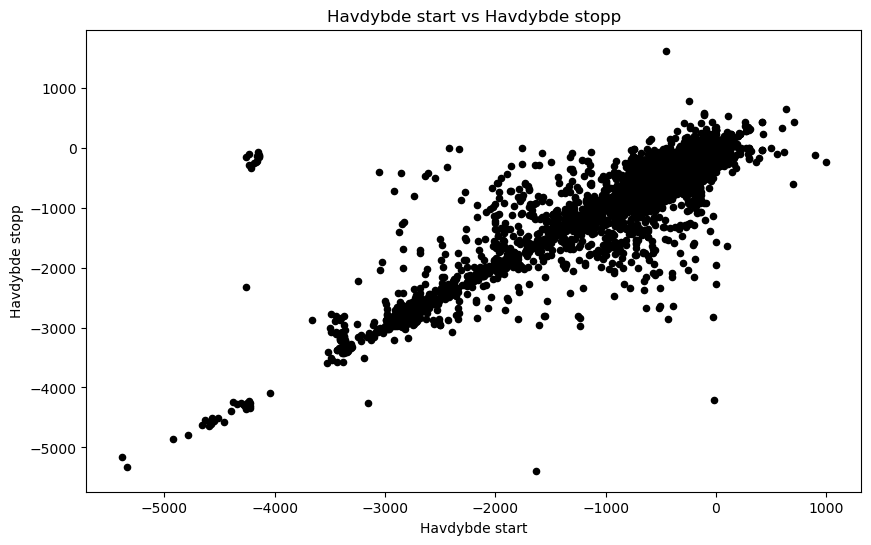

In [110]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train['Havdybde start'], df_train['Havdybde stopp'], c='black', s=20)
plt.xlabel('Havdybde start')
plt.ylabel('Havdybde stopp')
plt.title('Havdybde start vs Havdybde stopp')
plt.show()

Grafen viser at mesteparten av datapunktene plasserer seg langs diagonalen av grafen. Dette viser at verdiene i 'Havdybde start' og 'Havdybde stopp' er tilnærmet like hverandre. 

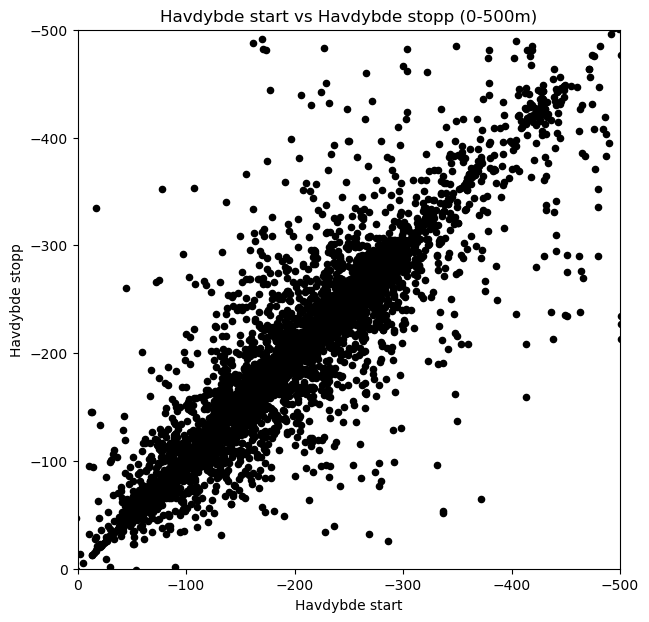

In [111]:
train_subset = df_train.iloc[:5000]

plt.figure(figsize=(7, 7))
plt.scatter(train_subset['Havdybde start'], train_subset['Havdybde stopp'], c='black', s=20)
plt.xlabel('Havdybde start')
plt.ylabel('Havdybde stopp')
plt.title('Havdybde start vs Havdybde stopp (0-500m)')
plt.xlim(0, -500)  
plt.ylim(0, -500)  
plt.show()

Dette utsnittet viser hvordan den samme fordelingen vises ved de 5000 første datapunktene. Her ser vi samme tendens som over. Ut ifra analysen velger vi å bruke gjennomsnitt. Deretter fjerner vi de originale kolonnene 'Havdybde start' og 'Havdybde stopp' til fordel for 'Dybde'.

In [112]:
def transform_Havdybde(data):

    data['Dybde'] = (data['Havdybde start'] + data['Havdybde stopp']) / 2
        
    data.drop(['Havdybde start', 'Havdybde stopp'], axis=1, inplace=True)
    
    return data

df_train = transform_Havdybde(df_train)
df_test = transform_Havdybde(df_test)


### Fjerne outliers

Vi fjerner outliers, eller ekstreme verdier, fra datasettet vårt.

#### Analyse av outliers
Nedenfor kan man se en representasjon av hvordan dataen er fordelt i 'Dybde', 'Varighet', 'Trekkavstand' og 'Skipsstørrelse'. Linjen inne i den blå boksen representerer medianen. Den strekker seg fra første til tredje kvartil. Med andre ord vil denne inneholde den midterste halvparten av all data. Strekene representerer et skille mellom ekstreme verdier og ikke-ekstreme verdier. Denne tar utgangspunkt i en faktor ganget med forskjellen fra første og tredje kvartil. I denne grafen er faktoren på 1.5.
Når man ser på dataen er det tydelig at dataen fordeler seg ulikt. For kolonnene 'Skipsstørrelse' og 'Trekkavstand' er det få outliers. I de to andre grafene ser vi en større andel outliers. Allikevel er avstanden i verdi veldig stor fra mesteparten av dataene. Siden vi har mye data har vi bestemt oss for å fjerne en stor andel ouliers. Dette førte til en forbedring ved maskinlæringsalgoritmene. 

<Axes: xlabel='Dybde'>

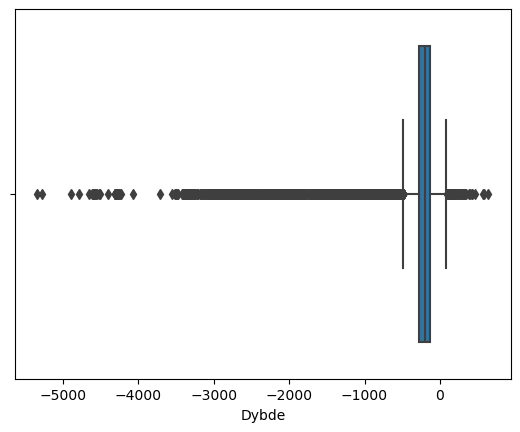

In [113]:
sns.boxplot(x=df_train['Dybde'])

<Axes: xlabel='Varighet'>

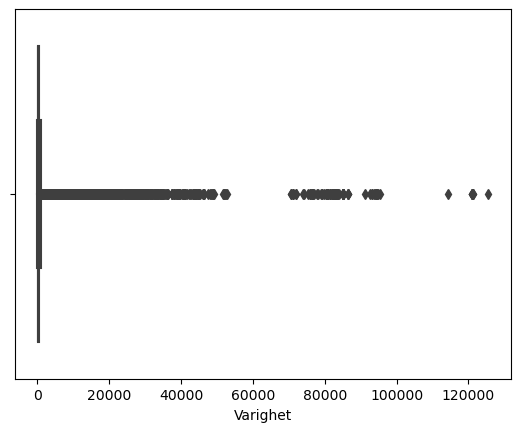

In [114]:
sns.boxplot(x=df_train['Varighet'])

<Axes: xlabel='Skipsstørrelse'>

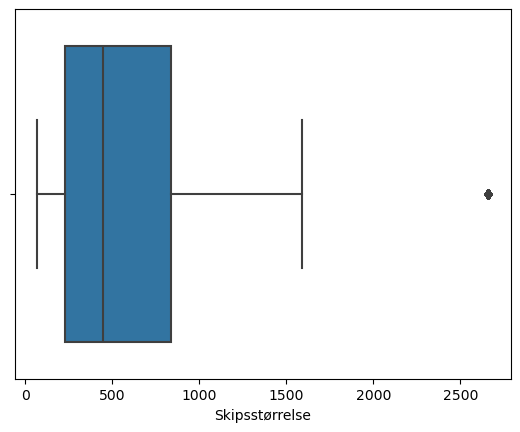

In [115]:
sns.boxplot(x=df_train['Skipsstørrelse'])

<Axes: xlabel='Trekkavstand'>

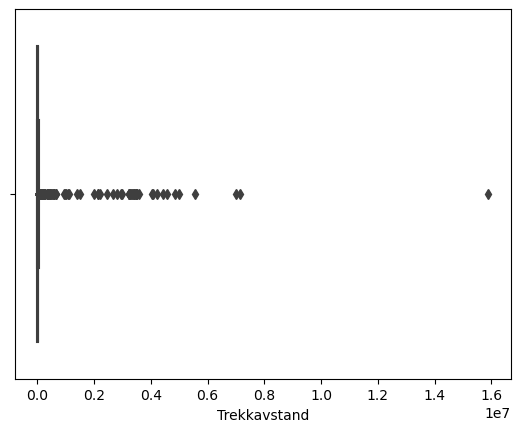

In [116]:
sns.boxplot(x=df_train['Trekkavstand'])

In [117]:
def remove_outliers_iqr(data, column, factor = 1.5):
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]

    return data

def remove_outliers_from_columns(data, columns, factor=1.5):
    for column in columns:
        data = remove_outliers_iqr(data, column, factor)
    return data

print("Train før fjerning: ",df_train.shape)
print("Train før fjerning: ",df_test.shape)

df_train = remove_outliers_from_columns(df_train, ['Skipsstørrelse', 'Trekkavstand'])
df_train = remove_outliers_from_columns(df_train, ['Varighet'], factor=7)
df_train['Dybde'] = df_train['Dybde'].clip(lower=-4000, upper=400) 


df_test = remove_outliers_from_columns(df_test, ['Skipsstørrelse', 'Trekkavstand'])
df_test = remove_outliers_from_columns(df_test, ['Varighet'], factor=7)
df_test['Dybde'] = df_test['Dybde'].clip(lower=-4000, upper=400)

print("Train etter fjerning: ",df_train.shape)
print("Train etter fjerning: ",df_test.shape)

Train før fjerning:  (84962, 16)
Train før fjerning:  (9441, 16)
Train etter fjerning:  (77719, 16)
Train etter fjerning:  (8370, 16)


### Redskaper
Oversikt over frekvensen av hvert unike redskap:

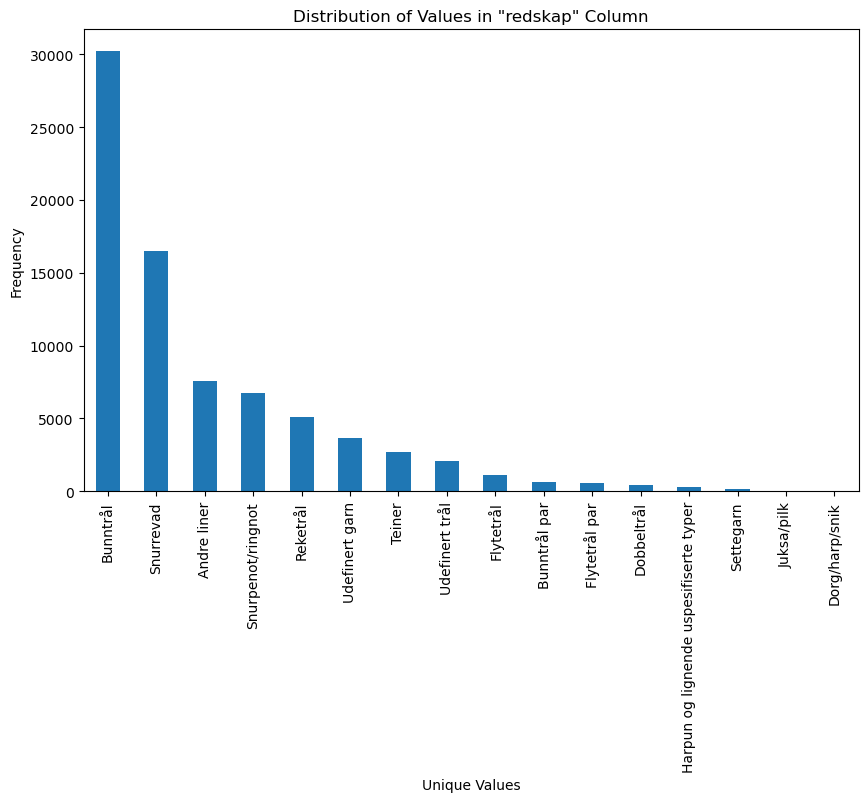

In [118]:
value_counts = df_train['Redskap FDIR'].value_counts()

plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Distribution of Values in "redskap" Column')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

Ut i fra grafen ovenfor og de unike redskapenes frekvens velger vi å fokusere på de spesifikke redskapene som skiller seg ut.
Vi ønsker å redusere antall unike verdier av redskaper før vi one-hot-encoder.
I og med at forskjellen på 'Bunntrål' og 'Bunntrål par' er at trålen drives av én båt isteden for to, velger vi å se på 'Bunntrål par' som en underkategori av 'Bunntrål'. Dermed kombinerer vi disse kategoriene.
Dog kan det argumenteres for at disse er to forskjellige redskap som vi ikke kjenner til. Dersom det var tilfelle at 'Bunntrål par' utgjorde en signifikant prosentandel av det totale datasettet ville det vært viktig å holde disse to separat, men siden 'Bunntrål par' kun utgjør 0.84% av frekvensen legger vi den til inn under 'Bunntrål'.

Vi kombinerer 'Bunntrål' og 'Bunntrål par'. I tillegg kombinerer vi 'Flytetrål', 'Flytetrål par', 'Dobbeltrål', 'Harpun og lignende uspesifiserte typer', 'Settegarn', 'Juksa/pilk', 'Dorg/harp/snik' til en ny kategori; 'Other'. Dette er fordi de ikke utgjør en signifikant prosentandel i datasettet. 

In [119]:
def replace_redskap(data):
    to_replace = ['Flytetrål', 'Flytetrål par', 'Dobbeltrål', 'Harpun og lignende uspesifiserte typer',
                  'Settegarn', 'Juksa/pilk', 'Dorg/harp/snik']
    replacement = 'Other'
    
    data['Redskap FDIR'].replace(to_replace, replacement, inplace=True)
    data['Redskap FDIR'].replace('Bunntrål par', 'Bunntrål', inplace=True)
    
    return data

df_train = replace_redskap(df_train)
df_test = replace_redskap(df_test)

#### One-hot-encoder Redskap FDIR

In [120]:
def one_hot_encode_redskap(data):
    columns_of_interest = ['Redskap FDIR']
    
    one_hot_encoded_df = pd.get_dummies(data[columns_of_interest], drop_first=True)
    one_hot_encoded_df = one_hot_encoded_df.astype(float)
    
    data.drop(columns=columns_of_interest, inplace=True)
    
    data = pd.concat([data, one_hot_encoded_df], axis=1)
    
    return data

df_train = one_hot_encode_redskap(df_train)
df_test = one_hot_encode_redskap(df_test)

### Beregning av gjennomsnittstidspunkt 
Vi beregner et gjennomsnittstidspunkt for hver fiskeaktivitet fordi vi ønsker å finne ut ca. når i løpet av døgnet hver fiskeaktivitet finner sted.
Erstatter kolonnen Startklokkeslett med Gjennomsnittstidspunkt. Lagt til Varighet/2, altså halve varigheten, til  Startklokkeslettet og for å finne gjennomsnittstidspunktet for fiskeaktiviteten. Dermed kan vi nå fjerne 'Startklokkeslett', ettersom dette vil være irrelevant informasjon. 
Vi velger å beholde varighet fordi vi mener at den er relevant for mengden fangst.

In [121]:
def beregn_gjennomsnittstidspunkt(starttidspunkt, varighet_minutter):
    starttid = datetime.strptime(starttidspunkt, '%H:%M')
    halvvarighet = timedelta(minutes=varighet_minutter / 2)
    gjennomsnittstid = (starttid + halvvarighet).time()
    return gjennomsnittstid.strftime('%H:%M')

df_train['Gjennomsnittstidspunkt'] = df_train.apply(
    lambda row: beregn_gjennomsnittstidspunkt(row['Startklokkeslett'], row['Varighet']), axis=1)

df_test['Gjennomsnittstidspunkt'] = df_test.apply(
    lambda row: beregn_gjennomsnittstidspunkt(row['Startklokkeslett'], row['Varighet']), axis=1)

df_train.drop(['Startklokkeslett'], axis=1, inplace=True)
df_test.drop(['Startklokkeslett'], axis=1, inplace=True)

### Trigonometrisk representasjon av dato
Vi ønsker å representere datoene ved hjelp av sin og cos verdier. Dette har vi gjort fordi det gir en måte å representere periodiske fenomener på en mer naturlig måte. Nederst er en graf som viser verdiene av sinus og cosinus.

/var/folders/w7/9jmmjp6x5pv0gg18t_rvk6xw0000gn/T/ipykernel_33377/4272110509.py:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_train['Startdato'] = pd.to_datetime(df_train['Startdato'])


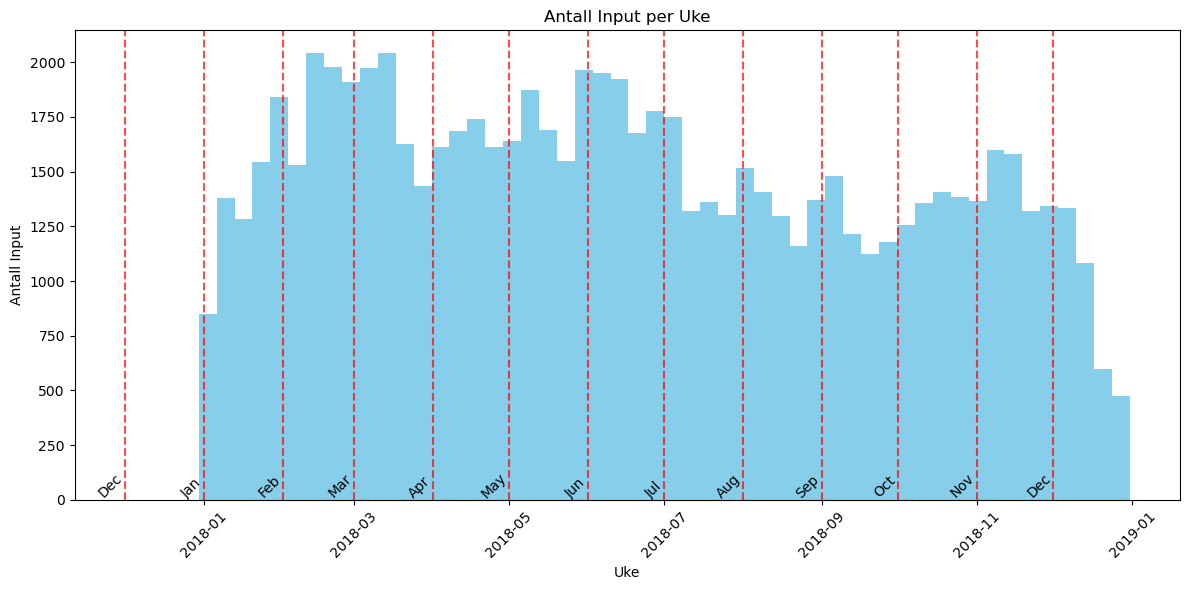

In [122]:
originalformat = df_train['Startdato']

df_train['Startdato'] = pd.to_datetime(df_train['Startdato'])

weekly_data = df_train.groupby(pd.Grouper(key='Startdato', freq='W')).size()

plt.figure(figsize=(12, 6))
plt.hist(df_train['Startdato'], bins=52, color='skyblue')
plt.title('Antall Input per Uke')
plt.xlabel('Uke')
plt.ylabel('Antall Input')
plt.xticks(rotation=45)

month_starts = df_train['Startdato'].dt.to_period('M').unique().to_timestamp()
for month_start in month_starts:
    plt.axvline(x=month_start, color='red', linestyle='--', alpha=0.7)
    month_name = calendar.month_abbr[month_start.month]
    plt.text(month_start, 10, month_name, rotation=45, ha='right')

df_train['Startdato'] = originalformat

plt.tight_layout()
plt.show()

In [123]:
def convert_day_sin(x): 
    difference = datetime.strptime(x, '%d.%m.%Y')-datetime(2018,1,1)
    c = difference.days
    return np.sin(c/365*2*np.pi)

def convert_day_cos(x): 
    difference = datetime.strptime(x, '%d.%m.%Y')-datetime(2018,1,1)
    c = difference.days
    return np.cos(c/365*2*np.pi)

In [124]:
df_train['Startdato_sin']=df_train.apply(lambda row: convert_day_sin(row['Startdato']), axis=1)
df_train['Startdato_cos']=df_train.apply(lambda row: convert_day_cos(row['Startdato']), axis=1)

df_test['Startdato_sin']=df_test.apply(lambda row: convert_day_sin(row['Startdato']), axis=1)
df_test['Startdato_cos']=df_test.apply(lambda row: convert_day_cos(row['Startdato']), axis=1)

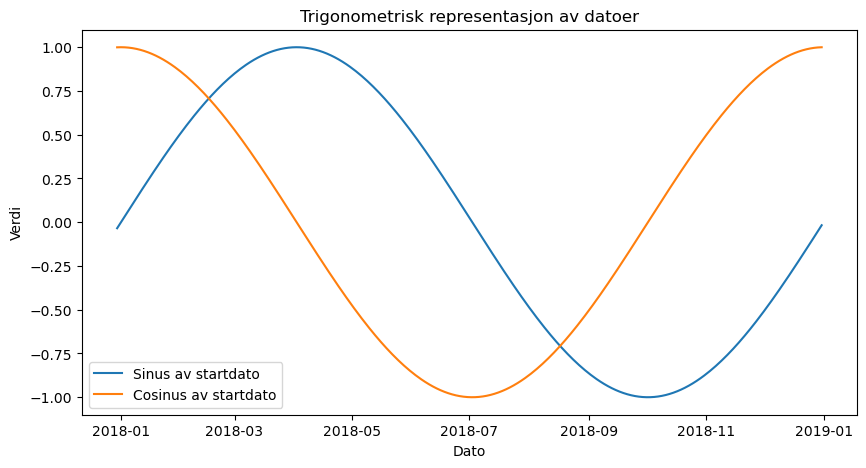

In [125]:
df_train['Startdato'] = pd.to_datetime(df_train['Startdato'], format='%d.%m.%Y')
df_train = df_train.sort_values('Startdato')

df_test['Startdato'] = pd.to_datetime(df_test['Startdato'], format='%d.%m.%Y')
df_test = df_test.sort_values('Startdato')

plt.figure(figsize=(10, 5))  
plt.plot(df_train['Startdato'], df_train['Startdato_sin'], label='Sinus av startdato')

plt.plot(df_train['Startdato'],df_train['Startdato_cos'], label='Cosinus av startdato')

plt.title('Trigonometrisk representasjon av datoer')
plt.xlabel('Dato')
plt.ylabel('Verdi')

plt.legend()

plt.show()

Over kan vi se hvordan sinusverdiene og cosinusverdiene forholder seg til hverandre. Grafen er jevn, som gir en indikasjon på at det er datapunkter fordelt over hele året. Det samme gjelder for tidsrepresentasjonene i løpet av døgnet som fungerer på samme vis. Det er verdt å merke seg at tidsrepresentasjonen er avhengig av begge dataformene. Dataen er ordnet syklisk, slik at desember og januar er like hverandre i tid. Senere forutsetter dette at begge kolonnene tas i bruk. I Decision trees vil dette for eksempel kunne være uheldig. Dataen ligger også på skalaen -1 til 1, som skiller seg fra mange av de andre kolonnene.

### Heatmap av syklisk encoding



Nedenfor kan man se en representasjonen av hvordan andelen inputs fordeler seg utover året. Her kan vi merke oss små forskjeller i andelen datapunkter i løpet av året. Ved nyttår kan vi merke oss at det er fisket lite, men at det fra januar og til mars er fisket mer. 

Som vi ser stemmer heatmappet overens med grafen vi har vist over. Vi har lagt inn månedene manuelt med hensyn til den foregående grafen. 

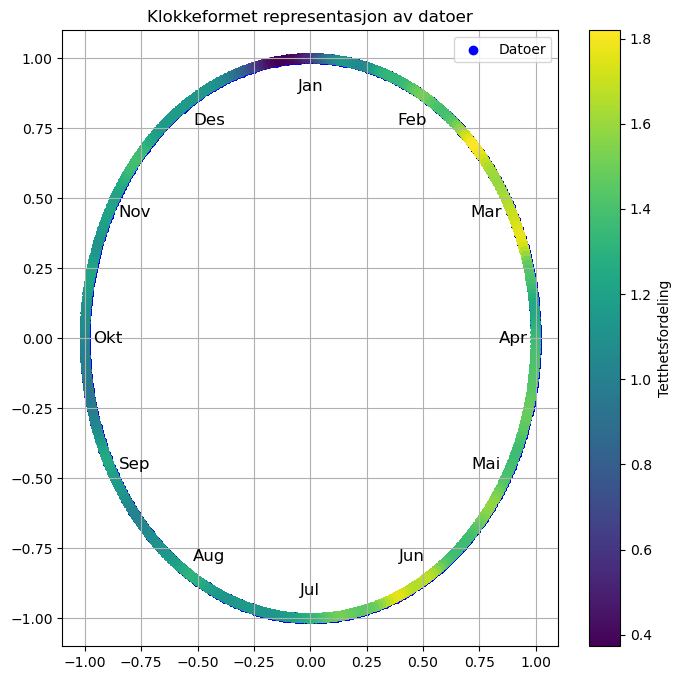

In [126]:
months = ['Apr', 'Mar', 'Feb', 'Jan', 'Des', 'Nov', 'Okt', 'Sep', 'Aug', 'Jul', 'Jun', 'Mai']

plt.figure(figsize=(8, 8))

plt.scatter(df_train['Startdato_sin'], df_train['Startdato_cos'], c='blue', label='Datoer')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

plt.title('Klokkeformet representasjon av datoer')

theta = np.linspace(0, 2*np.pi, len(months), endpoint=False)
for i, month in enumerate(months):
    x = np.cos(theta[i]) * 0.9 
    y = np.sin(theta[i]) * 0.9
    plt.text(x, y, month, fontsize=12, ha='center', va='center')

X = np.column_stack((df_train['Startdato_sin'], df_train['Startdato_cos']))
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(X)
densities = np.exp(kde.score_samples(X))

plt.scatter(df_train['Startdato_sin'], df_train['Startdato_cos'], c=densities, cmap='viridis')

cbar = plt.colorbar()
cbar.set_label('Tetthetsfordeling')

plt.grid(True)

plt.legend()
plt.show()


### Trigonometrisk representasjon av tidspunkt

Lager en sinus og en cosinusverdi for tidspunktet på dagen. Dette har vi gjort for at verdier nærme midnatt skal være likere enn verdier på svært forskjellige deler av dagen. Nederst er en graf som viser verdiene av sinus og cosinus.

In [127]:
def convert_min_sin(x): 
    time_obj = datetime.strptime(x, '%H:%M').time()
    midnight = datetime.strptime('00:00', '%H:%M').time()
    difference = datetime.combine(datetime.today(), time_obj) - datetime.combine(datetime.today(), midnight)
    c = difference.seconds / 60
    return np.sin(c / 1440 * 2 * np.pi)

def convert_min_cos(x): 
    time_obj = datetime.strptime(x, '%H:%M').time()
    midnight = datetime.strptime('00:00', '%H:%M').time()
    difference = datetime.combine(datetime.today(), time_obj) - datetime.combine(datetime.today(), midnight)
    c = difference.seconds / 60
    return np.cos(c / 1440 * 2 * np.pi)

In [128]:
df_train['Gjennomsnittstidspunkt_sin']=df_train.apply(lambda row: convert_min_sin(row['Gjennomsnittstidspunkt']), axis=1)
df_train['Gjennomsnittstidspunkt_cos']=df_train.apply(lambda row: convert_min_cos(row['Gjennomsnittstidspunkt']), axis=1)

df_test['Gjennomsnittstidspunkt_sin']=df_test.apply(lambda row: convert_min_sin(row['Gjennomsnittstidspunkt']), axis=1)
df_test['Gjennomsnittstidspunkt_cos']=df_test.apply(lambda row: convert_min_cos(row['Gjennomsnittstidspunkt']), axis=1)

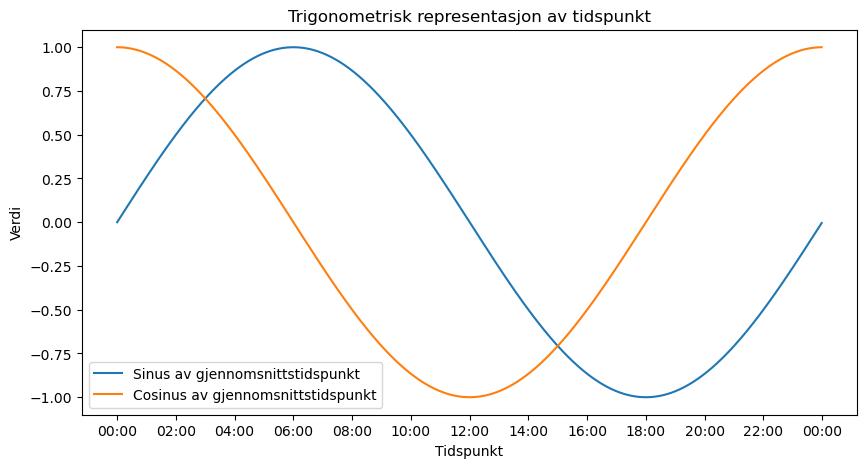

In [129]:
df_train['Gjennomsnittstidspunkt'] = pd.to_datetime(df_train['Gjennomsnittstidspunkt'], format='%H:%M')
df_train = df_train.sort_values('Gjennomsnittstidspunkt')

df_test['Gjennomsnittstidspunkt'] = pd.to_datetime(df_test['Gjennomsnittstidspunkt'], format='%H:%M')
df_test = df_test.sort_values('Gjennomsnittstidspunkt')

plt.figure(figsize=(10, 5))  
plt.plot(df_train['Gjennomsnittstidspunkt'], df_train['Gjennomsnittstidspunkt_sin'], label='Sinus av gjennomsnittstidspunkt')

plt.plot(df_train['Gjennomsnittstidspunkt'],df_train['Gjennomsnittstidspunkt_cos'], label='Cosinus av gjennomsnittstidspunkt')

plt.title('Trigonometrisk representasjon av tidspunkt')
plt.xlabel('Tidspunkt')
plt.ylabel('Verdi')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  

plt.legend()

plt.show()

### One-Hot-Encoding av årstider

Årsaken til at vi har valgt å one-hot-encode årstider er at vi ønsker å forbedre resultatene for to av supervised maskinlæringsmodellene vi har valgt å benytte. Med tanke på skalering av data ønsker vi å bruke årstider for Neural Networks og kNN, fremfor sinus og cosinus verdier. Derfor deler vi heller opp dataene i de fire forskjellige årstidene. Vi ser også en liten forbedring på resultatene, men dessverre ikke like mye som vi trodde og ønsket.

In [130]:
def get_season_numeric(date, season):
    month = date.month
    if month in [3, 4, 5]:
        return 1 if season == "Vår" else 0
    elif month in [6, 7, 8]:
        return 1 if season == "Sommer" else 0
    elif month in [9, 10, 11]:
        return 1 if season == "Høst" else 0
    else:
        return 1 if season == "Vinter" else 0

def apply_season_transformations(data, date_column):
    data[date_column] = pd.to_datetime(data[date_column])
    data['Vår'] = data[date_column].apply(lambda x: get_season_numeric(x, "Vår"))
    data['Sommer'] = data[date_column].apply(lambda x: get_season_numeric(x, "Sommer"))
    data['Høst'] = data[date_column].apply(lambda x: get_season_numeric(x, "Høst"))
    data['Vinter'] = data[date_column].apply(lambda x: get_season_numeric(x, "Vinter"))

apply_season_transformations(df_train, 'Startdato')

apply_season_transformations(df_test, 'Startdato')

Vi kan nå fjerne kolonnen 'Gjennomsnittstidspunkt' siden dette er representert ved 'Gjennomsnittstidspunkt_sin' og 'Gjennomsnittstidspunkt_cos'.

In [131]:
df_train.drop(['Startdato', 'Gjennomsnittstidspunkt'], axis=1, inplace=True)

df_test.drop(['Startdato', 'Gjennomsnittstidspunkt'], axis=1, inplace=True)

### Skalering

Vi ønsker å skalere vår numeriske data til en Min-Max skala for å sikre at alle våre features er på samme skala, er relative til hverandre og har lignende betydning for de maskinlæringsmodeller vi skal bruke senere i prosjektet.
Vi har valgt å ikke skalere våre target features (de 5 forskjellige rundevekt-verdiene) av hensyn til lesbarhet og representasjon. Vi tenker det kan være viktig å beholde target features uskalerte for å bevare den faktiske representasjonen av disse målingene, spesielt med tanke på at de skal tolkes direkte av andre mennesker og/eller andre systemer.

In [132]:
numerical_features = ['Trekkavstand', 'Dybde', 'Skipsstørrelse', 'Varighet','Startposisjon bredde', 'Startposisjon lengde','Stopposisjon bredde','Stopposisjon lengde']

scaler = MinMaxScaler()

df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])

df_test[numerical_features] = scaler.transform(df_test[numerical_features])

#### Dele inn i trening, test og validering
Som nevnt tidligere velger vi nå å dele opp treningssettet vårt. Vi tar 10% av dette og oppretter et valideringssett. 

Når vi ser på størrelsene så ser vi at på grunn av preprocessing er valideringssettet litt mindre enn testsettet, men de er fremdeles ca like store. 

In [133]:
target_features = ['Torsk - rundvekt', 'Sei - rundvekt', 'Hyse - rundvekt', 'Sild - rundvekt', 'Makrell - rundvekt']

def train_valid_test_split(data, valid_size=0.1, random_state=42):
    df_train, df_val = train_test_split(data, test_size=valid_size, random_state=random_state)
    return df_train, df_val

df_train, df_val = train_valid_test_split(df_train, valid_size=0.1, random_state=42)

X_train, Y_train = df_train.drop(target_features, axis=1), df_train[target_features]
X_val, Y_val = df_val.drop(target_features, axis=1), df_val[target_features]
X_test, Y_test = df_test.drop(target_features, axis=1), df_test[target_features]

print("Training set shape:", X_train.shape, Y_train.shape)
print("Validation set shape:", X_val.shape, Y_val.shape)
print("Test set shape:", X_test.shape, Y_test.shape)


Training set shape: (69947, 24) (69947, 5)
Validation set shape: (7772, 24) (7772, 5)
Test set shape: (8370, 24) (8370, 5)


### Machine learning modeller 

#### Decision tree

Den første modellen vi har valgt å trene vårt datasett på er decision trees. Decision trees er enkle å forstå, og den kan ha god ytelse på komplekse datasett. Decision trees kan være robuste på outliers i modellen, men har allikevel noen utfordringer som tendensen til overfitting og sensitiviteten overfor små endringer i dataene. Vi tenker allikevel at det er interessant å se på denne modellen. Decision trees kan også brukes både for klassifisering og regresjon, noe som gjør dem allsidige og anvendelige i ulike typer maskinlæringsoppgaver.

In [134]:
regressor = DecisionTreeRegressor()

regressor.fit(X_train, Y_train)

Y_pred_train = regressor.predict(X_train)

Y_pred_val = regressor.predict(X_val)

overall_mse_train = mean_squared_error(Y_train, Y_pred_train)
overall_mse_val = mean_squared_error(Y_val, Y_pred_val)

overall_r2_train = r2_score(Y_train, Y_pred_train)
overall_r2_val = r2_score(Y_val, Y_pred_val)

print(f"Overall Training - Mean Squared Error: {overall_mse_train}")
print(f"Overall Training - R-squared: {overall_r2_train}")
print(f"Overall Validation - Mean Squared Error: {overall_mse_val}")
print(f"Overall Validation - R-squared: {overall_r2_val}")

Overall Training - Mean Squared Error: 55.770797889830874
Overall Training - R-squared: 0.9999980836875755
Overall Validation - Mean Squared Error: 200916489.01752442
Overall Validation - R-squared: 0.404990341868559


#### Random Forest Regressor
Vi ser også på RandomForestRegressor som baseres på beslutningstrær. RandomForestRegressor har mange fordeler over enkle decision trees som bedre generalisering og parallelliserbarhet som gjør den egnet for store datasett. Ved gjennomsnittlige prediksjoner over flere trær og bruke tilfeldig funksjonsvalg, er tilfeldige skoger mindre utsatt for overfitting sammenlignet med individuelle decision trees.

In [135]:
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

random_forest_regressor.fit(X_train, Y_train)

Y_pred_train_rf = random_forest_regressor.predict(X_train)

Y_pred_val_rf = random_forest_regressor.predict(X_val)


overall_mse_train_rf = mean_squared_error(Y_train, Y_pred_train_rf)
overall_r2_train_rf = r2_score(Y_train, Y_pred_train_rf)

overall_mse_val_rf = mean_squared_error(Y_val, Y_pred_val_rf)
overall_r2_val_rf = r2_score(Y_val, Y_pred_val_rf)

print(f"Overall Training - Mean Squared Error: {overall_mse_train_rf}")
print(f"Overall Training - R-squared: {overall_r2_train_rf}")
print(f"Overall Validation - Mean Squared Error: {overall_mse_val_rf}")
print(f"Overall Validation - R-squared: {overall_r2_val_rf}")

Overall Training - Mean Squared Error: 17927372.97732846
Overall Training - R-squared: 0.9553762661369701
Overall Validation - Mean Squared Error: 103445221.35427079
Overall Validation - R-squared: 0.6943292048094548


#### Lineær regresjon

Vi trener også datasettet på lineær regresjon. Modellen forsøker å etablere et lineært forhold mellom de uavhengige variablene (X) og den avhengige variabelen (Y) ved å tilpasse en linje gjennom dataene. Den danner også et grunnlag for andre mer komplekse regresjonsmodeller og er derfor nyttig for å se om en enkel modell kan gi tilstrekkelig prediktiv ytelse. Med tanke på at både denne og andre tilnærminger vi har valgt å benytte er følsomme på outliers, har vi fjernet en god del outliers.

In [136]:
model = LinearRegression()

model.fit(X_train, Y_train)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)

r2_train = r2_score(Y_train, Y_pred_train)
mse_train = mean_squared_error(Y_train, Y_pred_train)

r2_val = r2_score(Y_val, Y_pred_val)
mse_val = mean_squared_error(Y_val, Y_pred_val)

print("Overall Training - Mean Squared Error:", mse_train)
print("Overall Training - R-squared:", r2_train)
print("Overall Validation - Mean Squared Error:", mse_val)
print("Overall Validation - R-squared:", r2_val)

Overall Training - Mean Squared Error: 348850856.0155296
Overall Training - R-squared: 0.1298758201445317
Overall Validation - Mean Squared Error: 312374009.3409611
Overall Validation - R-squared: 0.12458348876782069


#### Fjerner sin og cos verdier
Videre tenker vi å anvende neural network og KNN på datasettet. Algoritmer som disse bruker avstandsmålinger for å estimere likheter eller forskjeller mellom datapunkter. Hvis noen features har større skala enn andre, kan dette resultere i at modellen favoriserer eller vektlegger feilaktig de datane som ligger i større skalaer.

For oss er følgende numeriske verdier ikke på vår normaliserte skala fra 0 - 1:
'Startdato_sin',
'Startdato_cos',
'Gjennomsnittstidspunkt_sin',
'Gjennomsnittstidspunkt_cos'

Disse velger vi derfor å fjerne fra både fra X_train og X_val. Dog velger vi å beholde de for X_test fordi vi får bruk for disse verdiene.

In [137]:
columns_to_remove = ['Startdato_sin','Startdato_cos','Gjennomsnittstidspunkt_sin','Gjennomsnittstidspunkt_cos']

X_train.drop(columns=columns_to_remove)
X_val.drop(columns=columns_to_remove)

,Varighet,Startposisjon bredde,Startposisjon lengde,Stopposisjon bredde,Stopposisjon lengde,Trekkavstand,Skipsstørrelse,Dybde,Redskap FDIR_Bunntrål,Redskap FDIR_Other,Redskap FDIR_Reketrål,Redskap FDIR_Snurpenot/ringnot,Redskap FDIR_Snurrevad,Redskap FDIR_Teiner,Redskap FDIR_Udefinert garn,Redskap FDIR_Udefinert trål,Vår,Sommer,Høst,Vinter
21013,0.525142,0.945642,0.502495,0.945309,0.502666,0.115909,0.161526,0.850000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
56037,0.000437,0.932537,0.372047,0.932443,0.371894,0.008712,0.324133,0.729205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
13397,0.148666,0.933148,0.496023,0.933834,0.494263,0.582241,0.228610,0.833068,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
6878,0.030608,0.933058,0.474848,0.933010,0.474978,0.062426,0.034420,0.846250,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1
34932,0.299082,0.851891,0.415455,0.853444,0.414357,0.855538,0.059558,0.849773,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60687,0.110188,0.963583,0.538868,0.964081,0.538728,0.270393,0.709879,0.845227,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
65980,0.097508,0.953215,0.472369,0.953629,0.472053,0.238679,0.464424,0.856250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
33064,0.039353,0.966230,0.513070,0.966334,0.512788,0.104883,0.389171,0.845000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0
50148,0.163533,0.928505,0.505445,0.928329,0.505353,0.032717,0.372747,0.845795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0


#### Neural Network
Ved valget av en tilnærming innenfor Deep Learning har vi valgt å bruke Neural Networks. 
Et Multilayer Perceptron (MLP), som er en type nevrale nettverk, er et kraftig verktøy innen maskinlæring som kan håndtere komplekse, ikke-lineære mønstre/sammenhenger i dataene. Derfor har vi også valgt å bruke MLPRegressor. 
Vi velger å skalere variablene i datasettet når vi bruker denne modellen, men ikke selve målvariablene, altså target values. Dette er fordi det kan bidra til å forbedre ytelsen og konvergenshastigheten til neural networks modellen. 

In [138]:
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)

model.fit(X_train, Y_train)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)


mse_train = mean_squared_error(Y_train, Y_pred_train)
r2_train = r2_score(Y_train, Y_pred_train)

mse_val = mean_squared_error(Y_val, Y_pred_val)
r2_val = r2_score(Y_val, Y_pred_val)

print(f"Overall Training - Mean Squared Error: {mse_train:.4f}")
print(f"Overall Training - R-squared: {r2_train:.4f}")
print(f"Overall Validation - Mean Squared Error: {mse_val:.4f}")
print(f"Overall Validation - R-squared: {r2_val:.4f}")

Overall Training - Mean Squared Error: 179783556.7883
Overall Training - R-squared: 0.3670
Overall Validation - Mean Squared Error: 175426201.9758
Overall Validation - R-squared: 0.3421


#### K-nearest neighbors (kNN)

Vi velger å bruke denne modellen fordi det kan se ut til at den kan gi et godt resultat på datasettet vårt. Dette er fordi kNN fungerer godt når dataene er jevnt fordelt i funksjonsrommet, altså at klassene er klart definerte og separable. I og med at vi har et klart definert mål for datasettet ser vi på kNN som en passende modell. Noe som er spesielt viktig for at kNN skal fungere optimalt er å fjerne outliers, som vi har gjort.

In [139]:
model = KNeighborsRegressor(n_neighbors=5)

model.fit(X_train, Y_train)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)


mse_train = mean_squared_error(Y_train, Y_pred_train)
r2_train = r2_score(Y_train, Y_pred_train)

mse_val = mean_squared_error(Y_val, Y_pred_val)
r2_val = r2_score(Y_val, Y_pred_val)

print(f"Overall Training - Mean Squared Error: {mse_train:.4f}")
print(f"Overall Training - R-squared: {r2_train:.4f}")
print(f"Overall Validation - Mean Squared Error: {mse_val:.4f}")
print(f"Overall Validation - R-squared: {r2_val:.4f}")

Overall Training - Mean Squared Error: 129946681.6383
Overall Training - R-squared: 0.6107
Overall Validation - Mean Squared Error: 188828992.2348
Overall Validation - R-squared: 0.3912


### Analyse av modellenes prestasjon:

Basert på forskjellene i verdiene i MSE og R-squared modellene over ga oss, trekker vi følgende konklusjoner: 

Decision Trees:
- Modellen passer svært godt til treningsdataene, men viser en tendens til overfitting på valideringsdataene.

Random Forest Regressor:
- Modellen viser god ytelse på både trenings- og valideringssettene, men det kan være noe overfitting.

Lineær Regresjon:
- Modellen viser en svak til moderat tilpasning til dataene og har en høy MSE på både trenings- og valideringssettene.

Neural Net:
- Modellen viser moderat tilpasning til treningsdataene, men viser en tendens til overfitting.

k-nearest neighbors (kNN):
- Modellen viser moderat tilpasning til treningsdataene, men presterer noe dårligere på valideringsdataene.

Basert på denne analysen tenker vi at Random Forest Regressor har den beste ytelsen, med lav MSE og relativt høy R-squared på både trenings- og valideringssettene. Vi velger derfor å teste test settet vårt med Random Forest Regressor under. 

### Kjøre Random Forest Regressor på X_test

In [140]:
random_forest_regressor_final = RandomForestRegressor(n_estimators=100, random_state=42)

random_forest_regressor_final.fit(X_train, Y_train)

Y_pred_train_rf = random_forest_regressor_final.predict(X_train)

Y_pred_test_rf = random_forest_regressor_final.predict(X_test)


overall_mse_train_rf = mean_squared_error(Y_train, Y_pred_train_rf)
overall_r2_train_rf = r2_score(Y_train, Y_pred_train_rf)

overall_mse_test_rf = mean_squared_error(Y_test, Y_pred_test_rf)
overall_r2_test_rf = r2_score(Y_test, Y_pred_test_rf)

print(f"Overall Training - Mean Squared Error with Random Forests: {overall_mse_train_rf}")
print(f"Overall Training - R-squared with Random Forests: {overall_r2_train_rf}")
print(f"Overall Test - Mean Squared Error with Random Forests: {overall_mse_test_rf}")
print(f"Overall Test - R-squared with Random Forests: {overall_r2_test_rf}")

Overall Training - Mean Squared Error with Random Forests: 17927372.97732846
Overall Training - R-squared with Random Forests: 0.9553762661369701
Overall Test - Mean Squared Error with Random Forests: 97772260.39306419
Overall Test - R-squared with Random Forests: 0.7041017502105861


### Unsupervised learning - Clustering model
#### Alle rundvekter satt opp mot et utvalg features

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


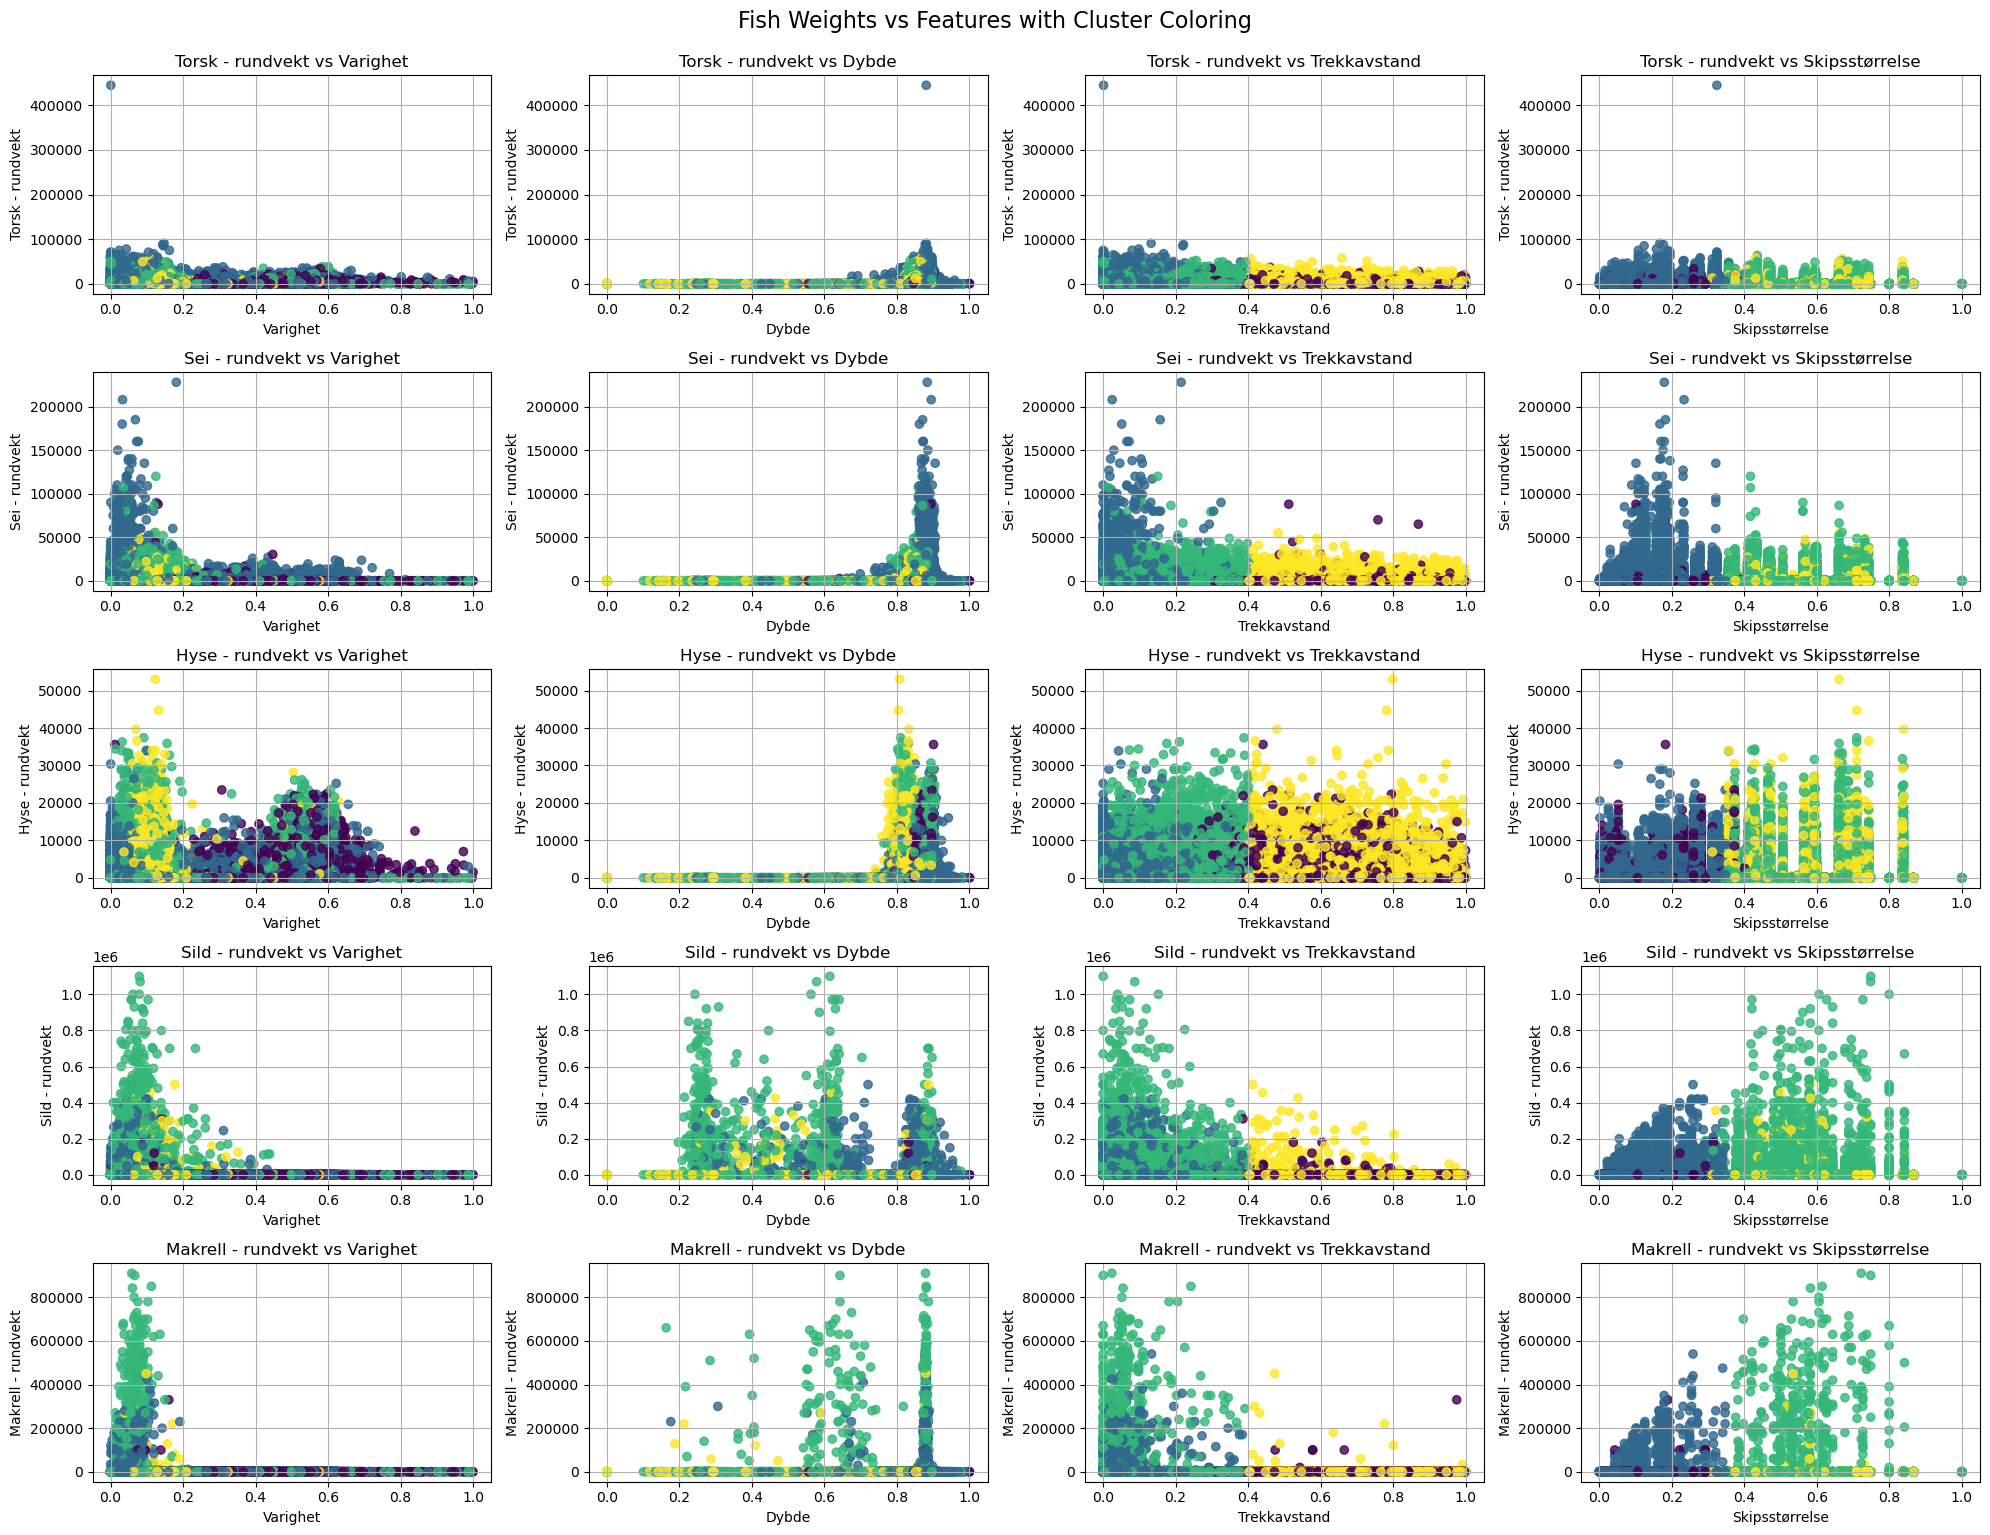

In [141]:
features = ['Varighet', 'Dybde', 'Trekkavstand', 'Skipsstørrelse']

fish_weights = ['Torsk - rundvekt', 'Sei - rundvekt', 'Hyse - rundvekt', 'Sild - rundvekt', 'Makrell - rundvekt']

X = df_train[features]

k = 4  

kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X)

df_train['Cluster'] = cluster_labels

fig, axes = plt.subplots(nrows=len(fish_weights), ncols=len(features), figsize=(20, 15))

for i, fish_weight in enumerate(fish_weights):
    for j, feature in enumerate(features):
        ax = axes[i, j]  
        ax.scatter(df_train[feature], df_train[fish_weight], c=df_train['Cluster'], cmap='viridis', alpha=0.8)
        ax.set_xlabel(feature)
        ax.set_ylabel(fish_weight)
        ax.set_title(f"{fish_weight} vs {feature}")
        ax.grid(True)
        if j == 0:
            ax.set_ylabel(fish_weight) 

plt.tight_layout()
plt.suptitle('Fish Weights vs Features with Cluster Coloring', y=1.02, fontsize=16)
plt.show() 

### Sammendrag - Unsupervised learning

#### Umiddelbare observasjoner
- Ved første øyekast oppstår det et tydelig skille mellom klynger som er over/under 0.4 på skalaen over skipsstørrelse, hvor gul og grønn klynge faller under, og blå/lilla klynga havner over.
- Det samme skille på 0.4 går igjen for trekkavstand. Her med lilla/grønn over 0.4, og gul og blå under 0.4.
- For trekkavstand er det også veldig tydelig, i tilfellet av torsk, sei og hyse, at klyngene dannes på intervalene 0.0-0.2 (gul), 0.2-0.4 (blå), mens grønn/lilla fordeler seg jevnt på resten. 

#### Likheter på tvers av grupper:
- Det fiskes generelt lite torsk. Det er en tydelig dybde hvor torsken fiskes som er ~0.83
- Dybden på ~0.83 er generelt et hyppig punkt for fiskeaktivitet. Hyse, sei og torsk fiskes nesten ekslusivt på denne dybden, mens makrell og sild er noe mer spredt.
- Det kommer fram at de aller fleste fiskeaktiviteter, uavhengig av klynge, har en tydelig topp mellom 0.0-0.2 (kort aktivitet). Dette er ikke like tydelig hos hyse, hvor det er en topp mellom 0.0-0.2, men den fortsetter å ha mange datapunkter over lenger varighet også. 
#### Likheter innad i de forskjellige gruppene:
- Gul klynge forteller oss at små båter også har generelt veldig kort trekkavstad. De fisker også der det er relativt grunnt (nærmere 1 på dybde = grunnere vann).
- Blå klynger ser ut til å ha kort varighet. Dette går igjen for alle fiskearter, men for hyse finner vi noen ekstremverdier midt i grafen.
- Grønn klynge forteller oss et par ting. Den har en viss korrelasjon til liten skipsstørrelse, men enda tydeligere kommer det frem at aktivitetene i denne klyngen kjennetegnes ved lang trekkavstand samt lengre enn normal varighet.
- Lilla klynge kjennetegnes ved en relativt høy skipsstørrelse og høy trekkavstand i kombinasjon med relativt kort varighet.  

### Sammendrag - Supervised learning
Som vist i analysen av maskinlæringsmodellene over, presterer for det meste modellene best på treningssettet og dårligere på valideringssett. Vår endelige test på X_test av vår beste modell Random Forest Regressor, fikk en litt bedre r-squared verdi enn samme modell fikk på X_val. Det er fortsatt en markant forskjell mellom hvor godt den presterer på trening vs. testset sin r-squared (0.95 vs. 0.70). Vi trekker derfor konklusjonen at modellene våre overfitter. Noen tiltak for å få modellene til å prestere bedre på validering og testsett er: 
- regularisering for å begrense modellens kompleksitet og dermed redusere overfitting. Dette kunne vi gjort ved bruk av f.eks Lasso- eller Ridge regularization. 
- tune hyperparameterene i modellene f.eks ved justering av antall trær, maksimal dybde og minimal leaf size i Random Forest-modellen. 
- feature engineering som fjerning av unødvendige eller korrelerte features og opprettelse av nye features. Her kunne vi gjort en PCA-analyse for å finne ut hvilke features som forteller oss mest om sammenhenger i dataen.
- vi kunne brukt cross-validation til å videre evaleure modellene våre. 
- kombinere flere modeller sammen for å forbedre generell ytelse og redusere variasjon.
- vi har ikke fjernet outliers for våre target features, noe som kan påvirke evnen modellene har til å predikere rundvekt. Gjennom clustering-modellen ser vi noen veldig tydelige ekstremverdiger hos torsk. Derfor skulle vi gjerne, med bedre tid, gjort en grundigere analyse av dette tidlig i oppgaven og deretter fjernet outlier for rundvekt, slik vi har gjort for resten av verdiene våre.
- vi har dessverre ikke gjort en analyse av Startposisjon bredde, Startposisjon lengde, Stopposisjon bredde, Stopposisjon lengde, som innebærer at de kan inneholde outliers, som kan påvirke skaleringen og dermed modellenes ytelse. 